[View in Colaboratory](https://colab.research.google.com/github/kintarou/django-starter/blob/master/Hidden_Markov_Model_PRML.ipynb)

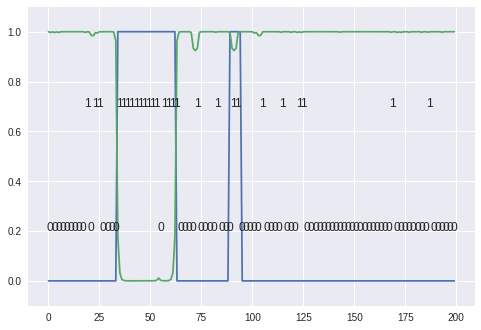

In [1]:
import matplotlib.pyplot as plt
import numpy as np


class HiddenMarkovModel(object):

    def __init__(self, n_states_hidden, n_states_observe):
        self.n_states_hidden = n_states_hidden
        self.n_states_observe = n_states_observe
        self.initial = np.ones(n_states_hidden) / n_states_hidden
        self.transition = np.ones((n_states_hidden, n_states_hidden)) / (2 * n_states_hidden)
        self.transition += np.eye(n_states_hidden) * 0.5
        self.observation = np.random.rand(n_states_observe, n_states_hidden)
        self.observation /= np.sum(self.observation, axis=0, keepdims=True)

    def fit(self, sequence, iter_max=100):
        for i in range(iter_max):
            params = np.hstack((self.transition.ravel(), self.observation.ravel()))
            p_hidden, p_transition = self.expectation(sequence)
            self.maximization(sequence, p_hidden, p_transition)
            if np.allclose(params, np.hstack((self.transition.ravel(), self.observation.ravel()))):
                break

    def expectation(self, sequence):
        N = len(sequence)
        forward = np.zeros(shape=(N, self.n_states_hidden))
        forward[0] = self.initial * self.observation[sequence[0]]
        backward = np.zeros_like(forward)
        backward[-1] = self.observation[sequence[-1]]
        for i in range(1, len(sequence)):
            forward[i] = self.transition.dot(forward[i - 1]) * self.observation[sequence[i]]
        for j in range(N - 2, -1, -1):
            backward[j] = (self.observation[sequence[j + 1]] * backward[j + 1]).dot(self.transition)
        p_hidden = forward * backward
        p_hidden /= np.sum(p_hidden, axis=-1, keepdims=True)
        p_transition = self.transition * (self.observation[sequence[1:]] * backward[1:])[:, :, None] * forward[:-1, None, :]
        p_transition /= np.sum(p_transition, axis=(1, 2), keepdims=True)

        return p_hidden, p_transition

    def maximization(self, sequence, p_hidden, p_transition):
        self.initial = p_hidden[0] / np.sum(p_hidden[0])
        self.transition = np.sum(p_transition, axis=0) / np.sum(p_transition, axis=(0, 2))
        self.transition /= np.sum(self.transition, axis=0, keepdims=True)
        x = p_hidden[:, None, :] * (np.eye(self.n_states_observe)[sequence])[:, :, None]
        self.observation = np.sum(x, axis=0) / np.sum(p_hidden, axis=0)


def create_toy_data(sample_size=100):

    def throw_coin(bias):
        if bias == 1:
            return np.random.choice(range(2), p=[0.2, 0.8])
        else:
            return np.random.choice(range(2), p=[0.8, 0.2])

    bias = np.random.uniform() > 0.5
    coin = []
    cheats = []
    for i in range(sample_size):
        coin.append(throw_coin(bias))
        cheats.append(bias)
        bias = bias + np.random.choice(range(2), p=[0.99, 0.01])
        bias = bias % 2
    coin = np.asarray(coin)

    return coin, cheats


def main():
    coin, cheats = create_toy_data(200)

    hmm = HiddenMarkovModel(2, 2)
    hmm.fit(coin, 100)
    p_hidden, _ = hmm.expectation(coin)

    plt.plot(cheats)
    plt.plot(p_hidden[:, 1])
    for i in range(0, len(coin), 2):
        plt.annotate(str(coin[i]), (i - .75, coin[i] / 2. + 0.2))
    plt.ylim(-0.1, 1.1)
    plt.show()


if __name__ == '__main__':
    main()